# Gesture Recognition

In [1]:
import numpy as np
import os
import datetime
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)
tf.config.list_physical_devices('GPU')

2024-03-14 17:19:06.593454: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 17:19:06.593481: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 17:19:06.593506: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-14 17:19:06.598566: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-14 17:19:08.384115: I tensorflow/compiler/

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Model

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Flatten, BatchNormalization, Activation, Dropout
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.layers import ConvLSTM2D

# Parameters initialization
is_lstm = False
nb_rows = 64   # X dimension of the image
nb_cols = 64   # Y dimesnion of the image
nb_frames = 12  # lenght of the video frames
nb_channel = 3 # numbe rof channels in images 3 for color(RGB) and 1 for Gray
nb_classes = 2 # number of classes

nb_filters = [8, 16, 32, 64]
nb_dense = [256, 128, nb_classes]

# Input
input_shape = (nb_frames, nb_rows, nb_cols, nb_channel)

# Define model
model = Sequential()

model.add(Conv3D(nb_filters[0], kernel_size=(3,3,3), input_shape=input_shape, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[1], kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[2], kernel_size=(1,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(nb_filters[3], kernel_size=(1,3,3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(1,2,2)))

#Flatten Layers
if not is_lstm:
    model.add(Flatten())
    model.add(Dense(nb_dense[0], activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(nb_dense[1], activation='relu'))
    model.add(Dropout(0.5))
else:
    model.add(
        ConvLSTM2D(
            filters=64,
            kernel_size=(3,3),
            strides=(1,1),
            padding='same',
            kernel_initializer='he_normal',
            recurrent_initializer='he_normal',
            return_sequences=True,
        )
    )
    model.add(
        ConvLSTM2D(
            filters=64,
            kernel_size=(3,3),
            strides=(1,1),
            padding='same',
            kernel_initializer='he_normal',
            recurrent_initializer='he_normal',
            return_sequences=True,
        )
    )
    model.add(
        ConvLSTM2D(
            filters=64,
            kernel_size=(3,3),
            strides=(1,1),
            padding='same',
            kernel_initializer='he_normal',
            recurrent_initializer='he_normal',
            return_sequences=True,
        )
    )
    model.add(GlobalAveragePooling3D())
    model.add(Dropout(0.5))

#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

2024-03-14 17:19:08.407742: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-14 17:19:08.407872: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-14 17:19:08.408096: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
class DataGenerator:
    def __init__(self, width=120, height=120, frames=30, channel=3, classes=5, crop=True, normalize=False, affine=False, flip=False, edge=False):
        self.width = width   # X dimension of the image
        self.height = height # Y dimesnion of the image
        self.frames = frames # length/depth of the video frames
        self.channel = channel # number of channels in images 3 for color(RGB) and 1 for Gray
        self.classes = classes # number of classes
        self.affine = affine # augment data with affine transform of the image
        self.flip = flip
        self.normalize =  normalize
        self.edge = edge # edge detection
        self.crop = crop

    # Helper function to generate a random affine transform on the image
    def __get_random_affine(self): # private method
        dx, dy = np.random.randint(-1.7, 1.8, 2)
        M = np.float32([[1, 0, dx], [0, 1, dy]])
        return M

    # Helper function to initialize all the batch image data and labels
    def __init_batch_data(self, batch_size): # private method
        batch_data = np.zeros((batch_size, self.frames, self.width, self.height, self.channel))
        batch_labels = np.zeros((batch_size, self.classes)) # batch_labels is the one hot representation of the output
        return batch_data, batch_labels

    def __load_batch_images(self, source_path, folder_list, batch_num, batch_size, t): # private method

        batch_data,batch_labels = self.__init_batch_data(batch_size)
        # We will also build a agumented batch data
        if self.affine:
            batch_data_aug,batch_labels_aug = self.__init_batch_data(batch_size)
        if self.flip:
            batch_data_flip,batch_labels_flip = self.__init_batch_data(batch_size)

        #create a list of image numbers you want to use for a particular video
        img_idx = [x for x in range(0, self.frames)]

        for folder in range(batch_size): # iterate over the batch_size
            # read all the images in the folder
            imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch_num*batch_size)].split(';')[0]))
            # Generate a random affine to be used in image transformation for buidling agumented data set
            M = self.__get_random_affine()

            #  Iterate over the frames/images of a folder to read them in
            for idx, item in enumerate(img_idx):
                image = cv2.imread(source_path+'/'+ t[folder + (batch_num*batch_size)].strip().split(';')[0]+'/'+imgs[item], cv2.IMREAD_COLOR)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                #crop the images and resize them. Note that the images are of 2 different shape
                #and the conv3D will throw error if the inputs in a batch have different shapes
                if self.crop:
                    image = self.__crop(image)
                # If normalize is set normalize the image else use the raw image.
                if self.normalize:
                    resized = self.__normalize(self.__resize(image))
                else:
                    resized = self.__resize(image)
                # If the input is edge detected image then use the sobelx, sobely and laplacian as 3 channel of the edge detected image
                if self.edge:
                    resized = self.__edge(resized)

                batch_data[folder,idx] = resized
                if self.affine:
                    batch_data_aug[folder,idx] = self.__affine(resized, M)
                if self.flip:
                    batch_data_flip[folder,idx] = self.__flip(resized)

            batch_labels[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1

            if self.affine:
                batch_labels_aug[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1

            if self.flip:
                if int(t[folder + (batch_num*batch_size)].strip().split(';')[2])==0:
                    batch_labels_flip[folder, 1] = 1
                elif int(t[folder + (batch_num*batch_size)].strip().split(';')[2])==1:
                    batch_labels_flip[folder, 0] = 1
                else:
                    batch_labels_flip[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1

        if self.affine:
            batch_data = np.append(batch_data, batch_data_aug, axis = 0)
            batch_labels = np.append(batch_labels, batch_labels_aug, axis = 0)
        if self.flip:
            batch_data = np.append(batch_data, batch_data_flip, axis = 0)
            batch_labels = np.append(batch_labels, batch_labels_flip, axis = 0)

        return batch_data, batch_labels

    def generator(self, source_path, folder_list, batch_size): # public method
        print( 'Source path = ', source_path, '; batch size =', batch_size)
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(folder_list)//batch_size # calculate the number of batches
            for batch in range(num_batches): # we iterate over the number of batches
                # you yield the batch_data and the batch_labels, remember what does yield do
                yield self.__load_batch_images(source_path, folder_list, batch, batch_size, t)

            # Code for the remaining data points which are left after full batches
            if (len(folder_list) != batch_size*num_batches):
                batch_size = len(folder_list) - (batch_size*num_batches)
                yield self.__load_batch_images(source_path, folder_list, num_batches, batch_size, t)

    # Helper function to perfom affice transform on the image
    def __affine(self, image, M):
        return cv2.warpAffine(image, M, (image.shape[0], image.shape[1]))

    # Helper function to flip the image
    def __flip(self, image):
        return np.flip(image,1)

    # Helper function to normalise the data
    def __normalize(self, image):
        # return image/127.5-1
        return image / 255.0

    # Helper function to resize the image
    def __resize(self, image):
        return cv2.resize(image, (self.width,self.height), interpolation = cv2.INTER_AREA)

    # Helper function to crop the image
    def __crop(self, image):
        if image.shape[0] != image.shape[1]:
            return image[0:120, 20:140]
        else:
            return image

    # Helper function for edge detection
    def __edge(self, image):
        edge = np.zeros((image.shape[0], image.shape[1], image.shape[2]))
        edge[:,:,0] = cv2.Laplacian(cv2.GaussianBlur(image[:,:,0],(3,3),0),cv2.CV_64F)
        edge[:,:,1] = cv2.Laplacian(cv2.GaussianBlur(image[:,:,1],(3,3),0),cv2.CV_64F)
        edge[:,:,2] = cv2.Laplacian(cv2.GaussianBlur(image[:,:,2],(3,3),0),cv2.CV_64F)
        return edge

In [5]:
def train(batch_size, num_epochs, model: tf.keras.models.Model, train_generator, val_generator, train_doc, val_doc, model_save_path=None, optimiser=None):

    curr_dt_time = datetime.datetime.now()

    num_train_sequences = len(train_doc)
    print('# training sequences =', num_train_sequences)
    num_val_sequences = len(val_doc)
    print('# validation sequences =', num_val_sequences)
    print('# batch size =', batch_size)
    print('# epochs =', num_epochs)

    #optimizer = Adam(lr=rate)
    #write your optimizer
    if optimiser == None:
        optimiser = Adam()
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    print (model.summary())

    model_name = model_save_path + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'best_model.h5'

    checkpoint = ModelCheckpoint(
        filepath,
        monitor='val_loss',
        mode='min',
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
    )

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
    callbacks_list = [checkpoint, LR]

    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    hist = \
        model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=num_epochs,
            verbose=1,
            callbacks=callbacks_list,
            validation_data=val_generator,
            validation_steps=validation_steps,
            class_weight=None,
            workers=1,
            initial_epoch=0,
        )

    # Save model (saved_model format)
    if model_save_path is None:
        tf.saved_model.save(model, 'saved_model')
    else:
        tf.saved_model.save(model, model_save_path)

    K.clear_session()
    return hist

In [6]:
batch_size = 64
num_epochs = 100
train_path = f'./data_{nb_rows}x{nb_cols}_{nb_frames:02d}_frames/train'
val_path = f'./data_{nb_rows}x{nb_cols}_{nb_frames:02d}_frames/val'
train_doc = np.random.permutation(open(f'./data_{nb_rows}x{nb_cols}_{nb_frames:02d}_frames/train.csv').readlines())
val_doc = np.random.permutation(open(f'./data_{nb_rows}x{nb_cols}_{nb_frames:02d}_frames/val.csv').readlines())
model_suffix = f'Nx3x{nb_frames}x{nb_rows}x{nb_cols}'
model_save_path = f'saved_model{"_lstm" if is_lstm else ""}_{model_suffix}'

train_gen = DataGenerator(width=nb_cols, height=nb_rows, frames=nb_frames, channel=nb_channel, classes=nb_classes, affine=False, flip=False, normalize=False, crop=False, edge=False)
val_gen = DataGenerator(width=nb_cols, height=nb_rows, frames=nb_frames, channel=nb_channel, classes=nb_classes)

train_generator = train_gen.generator(train_path, train_doc, batch_size)
val_generator = val_gen.generator(val_path, val_doc, batch_size)

hist = train(batch_size, num_epochs, model, train_generator, val_generator, train_doc, val_doc, model_save_path)

# training sequences = 806
# validation sequences = 200
# batch size = 64
# epochs = 100
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 64, 64, 8)     656       
                                                                 
 batch_normalization (Batch  (None, 16, 64, 64, 8)     32        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 16, 64, 64, 8)     0         
                                                                 
 max_pooling3d (MaxPooling3  (None, 8, 32, 32, 8)      0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 32, 32, 16)     3472      
                                 

Epoch 1/100


2024-03-14 17:19:09.898238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8900
2024-03-14 17:19:11.360124: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fea88016c20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-14 17:19:11.360139: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-03-14 17:19:11.363743: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-14 17:19:11.428885: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 [==============================] - ETA: 0s - loss: 0.9067 - categorical_accuracy: 0.6092Source path =  ./data_64x64_16_frames/val ; batch size = 64

Epoch 1: val_loss improved from inf to 2.23794, saving model to saved_model_Nx3x16x64x64/best_model.h5
13/13 [==============================] - 8s 323ms/step - loss: 0.9067 - categorical_accuracy: 0.6092 - val_loss: 2.2379 - val_categorical_accuracy: 0.4800 - lr: 0.0010
Epoch 2/100
 4/13 [========>.....................] - ETA: 0s - loss: 0.5201 - categorical_accuracy: 0.7895

/home/b920405/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - ETA: 0s - loss: 0.4026 - categorical_accuracy: 0.8462
Epoch 2: val_loss did not improve from 2.23794
13/13 [==============================] - 1s 76ms/step - loss: 0.4026 - categorical_accuracy: 0.8462 - val_loss: 3.2500 - val_categorical_accuracy: 0.4688 - lr: 0.0010
Epoch 3/100
 9/13 [===================>..........] - ETA: 0s - loss: 0.2604 - categorical_accuracy: 0.9006
Epoch 3: val_loss did not improve from 2.23794

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
13/13 [==============================] - 1s 84ms/step - loss: 0.2417 - categorical_accuracy: 0.9070 - val_loss: 5.9361 - val_categorical_accuracy: 0.4375 - lr: 0.0010
Epoch 4/100
12/13 [==========================>...] - ETA: 0s - loss: 0.5049 - categorical_accuracy: 0.8438
Epoch 4: val_loss improved from 2.23794 to 1.69361, saving model to saved_model_Nx3x16x64x64/best_model.h5
13/13 [==============================] - 0s 23ms/step - loss: 0.4909 - categori

INFO:tensorflow:Assets written to: saved_model_Nx3x16x64x64/assets


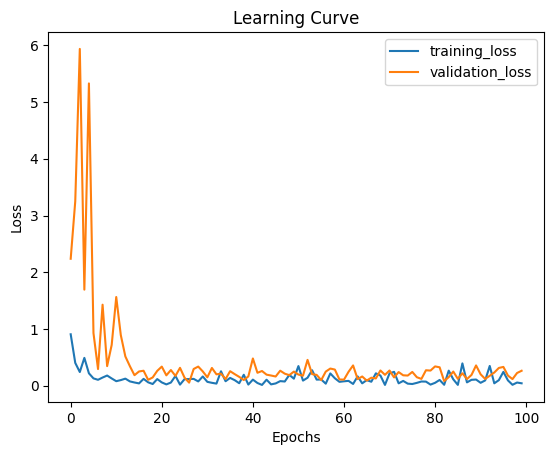

In [7]:
training_loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

## 推論用に ArgMax -> Bool 変換後処理の追加

In [8]:
# 保存したモデルのロード
model = tf.keras.models.load_model(f'{model_save_path}/best_model.h5')
# ArgMax -> Bool を追加
class PostModel(tf.keras.Model):
    def __init__(self, model):
        super(PostModel, self).__init__()
        self.base_model = model

    def call(self, inputs):
        x = self.base_model(inputs)
        return tf.cast(tf.math.argmax(x, axis=1), dtype=tf.bool)

# 新しいモデルのインスタンスを生成
model = PostModel(model)

## 推論テスト

In [9]:
predict_result = model.predict(np.ones([1, nb_frames, nb_cols, nb_rows, nb_channel], dtype=np.float32))
print(predict_result)
# 推論専用のモデルとして保存
tf.saved_model.save(model, model_save_path)

1/1 [==============================] - 0s 213ms/step
[False]


INFO:tensorflow:Assets written to: saved_model_Nx3x16x64x64/assets


INFO:tensorflow:Assets written to: saved_model_Nx3x16x64x64/assets


## 混同行列

Source path =  ./data_64x64_16_frames/val ; batch size = 1
200/200 [==============================] - 0s 1ms/step


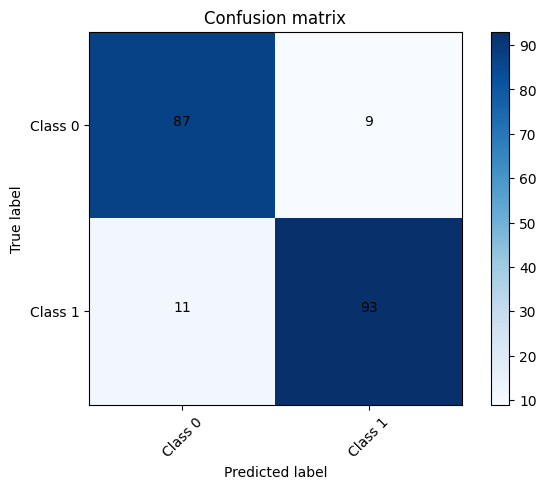

              precision    recall  f1-score   support

           0       0.89      0.91      0.90        96
           1       0.91      0.89      0.90       104

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200



In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import itertools

val_generator = val_gen.generator(source_path=val_path, folder_list=val_doc, batch_size=1)

val_datas = []
val_labels = []
for idx, (data, labels) in enumerate(val_generator):
    val_datas.append(data)
    val_labels.append(np.argmax(labels, axis=-1))
    if idx >= len(val_doc) - 1:
        break
val_datas = np.vstack(val_datas)
val_labels = np.asarray(val_labels).flatten()

predicted_classes = model.predict(val_datas, batch_size=1, steps=len(val_doc))
# predicted_classes = np.argmax(predictions, axis=1)

cm = confusion_matrix(val_labels, predicted_classes)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=[f'Class {i}' for i in range(nb_classes)], title='Confusion matrix')
plt.show()

report_dict = classification_report(val_labels, predicted_classes, output_dict=True)
print(classification_report(val_labels, predicted_classes))
acc = report_dict['accuracy']

## (テスト用) モデルをONNXに変換

In [11]:
onnx_save_path = f'{model_save_path}/waved_hand{"_lstm" if is_lstm else ""}_Nx3x{nb_frames}x{nb_rows}x{nb_cols}_acc{acc:.3f}.onnx'

!python -m tf2onnx.convert --saved-model $model_save_path --output $onnx_save_path --opset 11
!onnxsim $onnx_save_path $onnx_save_path

!sbi4onnx \
--input_onnx_file_path $onnx_save_path \
--output_onnx_file_path $onnx_save_path \
--initialization_character_string batch

!sor4onnx \
--input_onnx_file_path $onnx_save_path \
--old_new "output_1" "output" \
--mode outputs \
--search_mode prefix_match \
--output_onnx_file_path $onnx_save_path

!sne4onnx \
--input_onnx_file_path $onnx_save_path \
--input_op_names "StatefulPartitionedCall/post_model/sequential/conv3d/Conv3D__6:0" \
--output_op_names output \
--output_onnx_file_path $onnx_save_path

!sor4onnx \
--input_onnx_file_path $onnx_save_path \
--old_new "StatefulPartitionedCall/post_model/sequential/conv3d/Conv3D__6:0" "input" \
--mode inputs \
--search_mode prefix_match \
--output_onnx_file_path $onnx_save_path

!onnxsim $onnx_save_path $onnx_save_path

2024-03-14 17:19:39.939821: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 17:19:39.939849: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 17:19:39.939873: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2024-03-14 17:19:41,678 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2024-03-14 17:19:42,191 - INF